## Table of contents

* [1. Background](#Background)
* [2. Imports](#import)
* [3. Load the data](#Load_Data)
* [4. Is the data imbalanced?](#imblnc)
* [5. Definie predictive features and target feature](#define)
* [6. Appply One Hot Encoder to change the categorical columns](#OneHot)
* [7. Split the data to train and test sets](#split)
* [8. Choose the right metrics for model evaluation](#metrics)
* [9. Train models](#model)
    * [9.1. Logistic regression](#lr)
        * [9.1.1.  Make a pipeline for logistic regression model training](#pllr)
        * [9.1.2. Hyperparameter search using GridSearchCV for logistic regression](#gdlr)
        * [9.1.3. Best Logistic Regression model](#bestlr)
    * [9.2. Decision tree classifier](#dt)
        * [9.2.1. Make a pipeline for decision tree](#pldt)
        * [9.2.2. Hyperparameter search for decision tree classifier](#gddt)
        * [9.2.3. Decision tree classifier with best parameters](#bestdt)
        * [9.2.4. Feature importance assessment in the decision tree classifier](#fidt)
    * [9.3. Random forest classifier](#rf)
        * [9.3.1. Make a pipeline for random forest classifier](#plrf)
        * [9.3.2. Hyperparameter search for random forest classifier](#gdrf)
        * [9.3.3. Rondom forest classifier feature importance assessment](#firf)
    * [9.4. Gradient boosting classifier](#GB)
        * [9.4.1. Make a pipeline for gradient boosting classifier](#plgb)
        * [9.4.2. Hyperparameter tuning for gradient boosting classifier](#gdgb)
        * [9.4.3. Gradient boosting feature importance assessment](#figb)
* [10. Summary](#discussion)    

# 1. Background  <a class='anchor' id='Background'></a>

In this notebook we will apply several calssification models to our cleaned data frame of accepted loans from Lending Club. Briefly, Lending Club used to be the biggest peer to peer lending platform. To decide about a loan application, Lending Club relies on applicants' information provided during application. Such information includes income, length employment and credit history. In previous notebooks, we addressed missing data and explore the data to get a better understanding of the data 

In this notebook we will apply several classification models to predict if a loan will default. The models are:

1. Logistic regression

2. Decision tree

3. Random Forest

4. XGBoost



# 2. Imports <a class='anchor' id='import'></a>

We start by importing required packages.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

# 3. Load the data<a class='anchor' id='Load_Data'></a>

Using the pd.read_csv, we load the data

In [59]:
df = pd.read_csv("C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv")

# 4. Is the data imbalanced? <a class='anchor' id='imblnc'><a/>

A data set is called [imbalanced](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), if the minority class makes a small percentage of the data set. 

If the minority class (in our case the defaulted loans) makes 20 to 40% of a data set, then it is mildly imbalance.
if the minority class is 1 to 20%, then the dataset is moderately imbalanced and if minority class is < 1% of data set, the data is extremely imbalanced.

To find out if our data set is imbalanced or not, we will look at waht percentages of loan applications in the data frame is defaulted

In [60]:
df.Status.value_counts()/len(df)

Fully Paid    0.784132
Default       0.215868
Name: Status, dtype: float64

Default loans count for 22% of our data set. Therefore, our data is mildly imbalance, which may or may not be a problem. It is suggested to model with the true distribution and if it was not fine, apply techncis such as undersampling to deal with the imbalance.

# 5. Define predictive features and target feature  <a class=anchor, id='define'></a>

X is the dataframe that has the predictive features and y is the target column. X includes applicants' information and y is the status of the loan, which is either _Fully paid_ or _Default_. We also drop unnecessary columns including 'id' and 'grade'. The later is redundent. because there is _sub grade_ feature which includes grade.

In [61]:
# Defining X and y

y = df['Status']
X = df.drop(columns=['Status', 'id', 'Unnamed: 0', 'grade', 'verification_status'])

In [62]:
# Check if all columns are available! 
X.columns

Index(['revol_util', 'dti', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'inq_last_6mths', 'open_acc', 'mort_acc',
       'annual_inc', 'sub_grade', 'funded_amnt', 'installment', 'int_rate',
       'term', 'revol_bal', 'fico_range_high', 'fico_range_low', 'emp_length',
       'home_ownership', 'num_rev_accts', 'pub_rec_bankruptcies', 'tax_liens',
       'Credit Length (year)'],
      dtype='object')

# 6. Appply One Hot Encoder to change the categorical columns <a class=anchor id='OneHot'></a>

After droping unnecessary columns and defining our features and target column, we need to address categorical features. To change categorical features to numerical columns, _One Hot Encoder_  is used.

In [63]:
# Choosing the categorical columns

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# creating instance of one-hot-encoder

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)

In [64]:
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from 43 to', X.shape[1])

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 43 to 71


# 7. Split the data to train and test sets <a class='anchor' id='split'></a>

After encoding the categorical features, we use train_test_split to split the data set into train and test sets.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

# 8. Choose the right metrics for model evaluation <a class='anchor' id='metrics'></a>

Given that the data is mildly imbalanced, accuracy score is not a good metrics to evaluate performance of a model. It is [recommended](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html#:~:text=1%20Use%20the%20right%20evaluation%20metrics.%20Applying%20inappropriate,keep%20the%20models%20as%20a%20fixed%20component.%20) to use evaluation metrics such as precision, recal, f1 score or balanced accuracy. We use "balanced accuracy" as our evaluation metrics to compare model performance.

Furthermore, we define three functions to assess model performance. Given that there are so many categorical columns, each categorical column results in creation of several parameters. The first function _feature_importance_, insure that the resulted coefficiencts are combined together and presented as a single parameter. The second function, _plot_feature_importance_ helps with visualizing the results of models and importance of features and the last function plots the confusion matrix. 


In [66]:
def feature_importance(model):
    model_features = pd.DataFrame(model.feature_importances_)
    model_features.index = X.columns
    model_features.columns=['Importance']
    HO = model_features.loc['home_ownership_ANY':,:]
    HO = pd.DataFrame({'Importance': HO.mean()})
    HO.index = ['home_ownership']
    Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
    Emp = pd.DataFrame({'Importance': Emp.mean()})
    Emp.index = ['employment length']
    Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
    sub = pd.DataFrame({'Importance': Sub.mean()})
    sub.index = ['sub_grade']
    term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
    term.index = ['term']

    model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub])
    return model_features

In [67]:
def plot_feature_importance(model_features, title):
    
    fig, ax=plt.subplots()
    model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
    ax.set_title(title)
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Feature')


In [68]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    classes = ['Default', 'Fully Paid']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# 9. Train models <a class='anchor' id='model'></a>

The models that we will apply are:

1. Logistic regression

2. Decision tree

3. Random Forest

4. XGBoost


These are the steps we follow for each model:

1. Make a pipeline, that includes the model and scaling steps 

2. Grid search to find the hyperparameters

3. Train the model with the best hyperparameters

4. Apply the model to the test data and perform feature importance assessment 



## 9.1. Logistic regression <a class='anchor' id='lr'></a>

### 9.1.1.  Make a pipeline for logistic regression classifier <a class='anchor' id='pllr'></a>

Using make_pipeline, a pipeline is created to train logistic regression classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [69]:
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)

### 9.1.2. Hyperparameter search using GridSearchCV for logistic regression <a class='anchor' id='gdlr'></a>

Logistic regression has several parameters to tune. These parameters are shown by using get_params().keys(). Given the computing power constraints, a small though important number of features are chosen to tune. These parameters are learning rate and penalty.

In [14]:
# Checking logistic regression available parameters
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'logisticregression', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [15]:
# Define a set of parameters for grid search
grid_params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.001,0.01,0.1,1,10,100,1000]}

In [16]:
# Perform grid search
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2']})

### 9.1.3. Best Logistic Regression model <a class='anchor' id='bestlr'></a>

Now that we know the best hyperparameters for Logistic Regression, we will model with the best parameteres and look at the cofficients of features.

In [17]:
# Get the best parameters
lr_grid_cv.best_params_

{'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}

In [20]:
# Fit the logistic regression model with tuned parameters

model=LogisticRegression(penalty='l2',C=10,solver='newton-cg')
pipeLrBest = make_pipeline(MinMaxScaler(), model)
pipeLrBest.fit(X_train,y_train)

y_pred = pipeLrBest.predict(X_train)
y_pred =pd.Series(y_pred)

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

y_pred = pipeLrBest.predict(X_test)
y_pred =pd.Series(y_pred)
#roc_auc_score(y_test, y_pred)
print('For the testing set, the balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))


For the training set, the balanced accuracy is:  0.5330082813236712
For the testing set, the balanced accuracy is:  0.5330388327020615


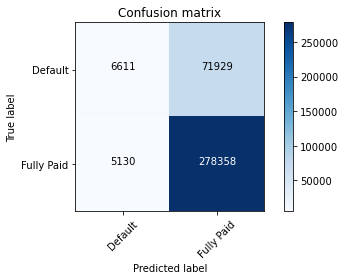

In [22]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

The balanced accuracy for the testing and training sets are similar. Therefore, the model is not overfitting. However, it performs very poorly.


## 9.2. Decision tree classifier <a class='anchor' id='dt'></a>
 


### 9.2.1. Make a pipeline for decision tree <a class='anchor' id='pldt'></a>

Using make_pipeline, a pipeline is created to train decision tree classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [70]:
# Make pipeline

pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)

### 9.2.2. Hyperparameter search for decision tree classifier <a class='anchor' id='gddt'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [24]:
# Define grid parameters

grid_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'], 'decisiontreeclassifier__max_depth': [3, 6, 9]}

In [25]:
# Perform grid search to find hyperparameters of decision tree

tree_grid_cv = GridSearchCV(pipeTree, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
tree_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9]},
             scoring='balanced_accuracy')

### 9.2.3. Decision tree classifier with best parameters <a class='anchor' id='bestdt'></a>

We access the best parameters by using grid.best_params_

In [26]:
tree_grid_cv.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 9}

We fit a decision tree to the training data by using the best hyperparameters and then, we will look at the importance of the features.

In [71]:
BestTree = tree.DecisionTreeClassifier(criterion="gini", max_depth =9, random_state = 1234)
pipeTreeBest = make_pipeline(BestTree)
pipeTreeBest.fit(X_train, y_train)


y_pred = pipeTreeBest.predict(X_train)
y_pred =pd.Series(y_pred)

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

y_pred = pipeTreeBest.predict(X_test)
y_pred =pd.Series(y_pred)

print('For the testing set, the balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))

For the training set, the balanced accuracy is:  0.5367442411547779
For the testing set, the balanced accuracy is:  0.5325381913301601


It can be seen that the balanced accuracy of the decision tree model is 0.53. The model is performing very poorly, which is probably due to the imbalanced data. In the next step using our two function defined initially, we visualize relative importance of our features.

In [30]:
from sklearn.tree import export_graphviz

import os     
from io import StringIO  

os.environ["PATH"] += os.pathsep + 'C://Users//somfl//Anaconda3//Library//bin//graphviz'

# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(BestTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['Fully Paid', 'Default'])
# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

184 [label=<emp_length_< 1 year &le; 0.5<br/>gini = 0.267<br/>samples = 2777<br/>value = [441, 2336]<br/>class = Default>, fillcolor="#5eb0ea"] ;
    ^
Expected "}", found '['  (at char 25163), (line:371, col:5)


AttributeError: 'NoneType' object has no attribute 'create_png'

### 9.2.4. Feature importance assessment in the decision tree classifier <a class='anchor' id='fidt'></a>

Using the function I initially defined, I will get the importance of features in the decision tree model.

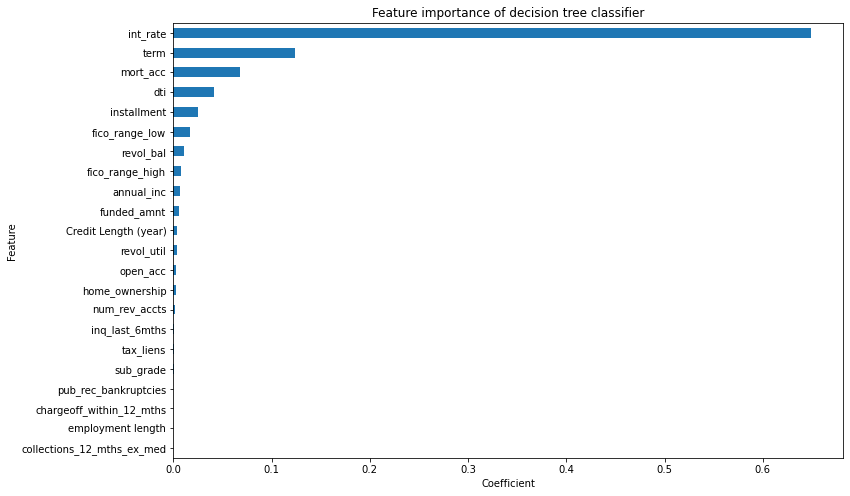

In [72]:
model_features = feature_importance(pipeTreeBest.named_steps.decisiontreeclassifier)
title='Feature importance of decision tree classifier'
plot_feature_importance(model_features, title)

According to the feature importance plot, _interest rate_, _loan term_(either it is 30 month or 60 month loan), _number of mortages_, _debt to income ratio_, _installment_, _Low Fico score_, _revolving balance_ and _high Fico score_ are the most influential parameters in decision tree classifier. Interest rate has a more significant effect than the other parameters.   

Furthermore, number of _tax liens_, _sub grade_, _bank ruptcies_, _employment length_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 9.3. Random forest classifier <a class='anchor' id='rf'></a>

### 9.3.1. Make a pipeline for random forest classifier <a class='anchor' id='plrf'></a>

Using make_pipeline, a pipeline is created to train random forest classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [73]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))

### 9.3.2. Hyperparameter search for random forest classifier <a class='anchor' id='gdrf'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [74]:
pipeRF.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('randomforestclassifier', RandomForestClassifier(random_state=47))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'randomforestclassifier': RandomForestClassifier(random_state=47),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestcl

In [75]:
# Define a grid for hyperparameter tuning with GridSearchCV
param_grid = { 
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth' : [3, 6, 9],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}


In [34]:
rf_grid_cv  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)
rf_grid_cv.fit(X_train, y_train)
rf_grid_cv.best_params_

KeyboardInterrupt: 

### 9.3.3. Feature importance assessment of random forest classifier <a class='anchor' id='firf'></a>

We fit a random forest classifier to the training data by using the best hyperparameters. Then we will use the model on the test data and will check to see the balanced accuracy score of the model. Finally, we will look at the importance of the features.

In [76]:
BestRF = RandomForestClassifier(criterion="gini", max_depth =9, random_state = 47, n_estimators=50)
pipeRFBest = make_pipeline(MinMaxScaler(), BestRF)
pipeRFBest.fit(X_train, y_train)

y_pred = pipeRFBest.predict(X_train)
y_pred =pd.Series(y_pred)

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

y_pred = pipeRFBest.predict(X_test)
y_pred =pd.Series(y_pred)

print('For the testing set, the balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))

For the training set, the balanced accuracy is:  0.5026606740962785
For the testing set, the balanced accuracy is:  0.502452755183901


The balanced accuracy score of the random forest is 50% which means the model is performing very poorly. When compared with the decision tree classifier and the logistic regression classifier, which had 0.54 balanced accuracy scores, random forest is a bit worse.

Using the two functions we visualize the relative importance of the parameters.

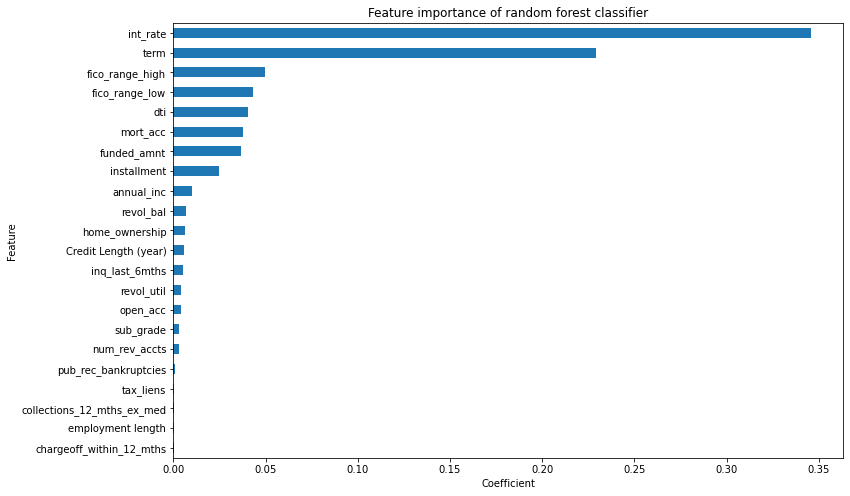

In [77]:
# Plot feature importance for random forest

model_features = feature_importance(pipeRFBest.named_steps.randomforestclassifier)
title='Feature importance of random forest classifier'
plot_feature_importance(model_features, title)

As shown in the plot,  _interest rate_, _loan term_(either it is 30 month or 60 month), _higher Fico score_ and _low Fico score_, _debt to income ratio_ , _number of mortages_, _funded amount_ and _installment_ are the most influential parameters.

It is worth mentioning that the decision tree reached to almost similar conclusion in the previous section. In a decision tree classifier, the most influential parameters were interest rate, loan term(either it is 30 month or 60 month loan), number of mortages, debt to income ratio, installment, Low Fico score, revolving balance and high Fico score.  

Furthermore, Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 9.4. Gradient boosting classifier <a class='anchor' id='GB'></a>

### 9.4.1. Make a pipeline for gradient boosting classifier <a class='anchor' id='plgb'></a>

Using make_pipeline, a pipeline is created to train gradient boosting classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [78]:
pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier())

### 9.4.2. Hyperparameter tuning for gradient boosting classifier <a class='anchor' id='gdgb'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [236]:
parameters = {
    'xgbclassifier__max_depth':[3, 6, 9],
#    'xgbclassifier__max_delta_step':[0,0.05],
#    'xgbclassifier__scale_pos_weight':[0.95, 0.9],
#    'xgbclassifier__subsample':[1,0.8],
    'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
#    'xgbclassifier__min_child_weight':[0,1,2],
    'xgbclassifier__gamma':[1, 2, 3]
    }
grid_search = GridSearchCV(pipeXG, param_grid= parameters, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_train,y_train)

C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:11:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:19:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:28:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\somfl\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

### 9.4.3. Gradient boosting feature importance assessment <a class='anchor' id='figb'></a>

In [81]:
BestXG = XGBClassifier(random_state=47,gamma=2, learning_rate=0.25, max_delta_step=0, min_child_weight=0,  subsample=1, n_estimators=10)
pipeXgBest = make_pipeline(MinMaxScaler(), BestXG)
pipeXgBest.fit(X_train, y_train)

y_pred = pipeXgBest.predict(X_train)
y_pred = pd.Series(y_pred) 

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

y_pred = pipeXgBest.predict(X_test)
y_pred =pd.Series(y_pred)

print('For the testing set, the balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))

[12:22:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the training set, the balanced accuracy is:  0.5261816216790653
For the testing set, the balanced accuracy is:  0.5253736836682769


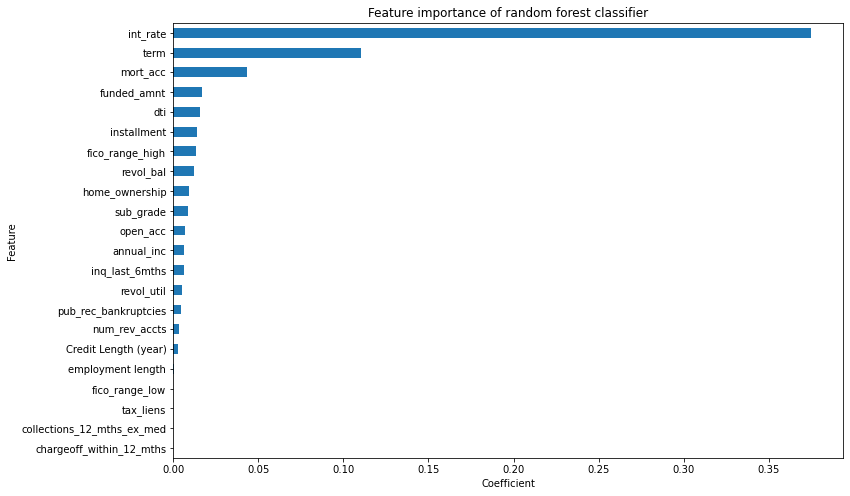

In [84]:
model_features = feature_importance(pipeXgBest.named_steps.xgbclassifier)
Title = ' Feature importance for gradient boosting classifier'
plot_feature_importance(model_features, title)

According to the balanced accuracy score, gradient boosting is better than random forest but as not as good decision tree or logistic regression clasiifiers. However, the score is 52% and the models performs poorly.

According to the feature importance plot, _interest rate_, _term_, the number of _mortage accounts_ , _funded amount_, _debt to income ratio_, _installment_, _high Fico score_ and _revolving balance are the most influential parameters in the classification. _interset rate_ has a significant effect compared with other parameters.

Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 10. Summary <a class='anchor' id='discussion'><a/>

In this notebook four classifiers were applied to the data.
In each model training, a pipeline including scaling and modeling steps was created and bu using GridSearchCV, hyperparameters were tuned. 

All models reached to almost same balanced accuracy score of about %54, which is due to the fact that the data is imbalanced.

Random forest classifier, decision tree and gradient boosting, they all found _interest rate_, _term_, the number of _mortage accounts_ , _funded amount_, _debt to income ratio_, _installment_, _Fico score_ as influential parameters.

According to all models _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.